# Guided Project: Task 2A: Image-Caption Retrieval with CLIP

This notebook implements image-to-caption retrieval using CLIP (Contrastive Language-Image Pretraining).

## Names
1. Diego Bermudez Sierra - dabermud@andrew.cmu.edu
2. Santiago Bolaños Vega - sbolaosv@andrew.cmu.edu

## Objectives:
1. Load pretrained CLIP model from Hugging Face
2. Compute embeddings for images and captions
3. Perform image-to-caption retrieval using cosine similarity
4. Evaluate retrieval performance with multiple metrics:
   - Recall@K (instance-level and class-aware)
   - BERTScore
   - CLIPScore
   - Mean Average Precision (MAP)

## AI Acknowledgement
This task was completed with assistance from an AI coding assistant (Auto, powered by Cursor) that helped implement and debug the code for Task 2A: Image-Caption Retrieval with CLIP. The assistant provided guidance on environment setup, resolved PyTorch CUDA compatibility issues, fixed CLIP model loading with safetensors support, corrected data loading functions to properly parse the captions.txt file format, and helped configure the GPU environment on Bridges2. All code implementations, debugging, and final solutions were developed collaboratively through iterative problem-solving sessions.

In [20]:
config = {
    'root_eeg': "/jet/home/bermudez/exploring-eeg/4-eeg-classifiers",
    'root_clip': "/jet/home/bermudez/exploring-eeg/5-caption-retrieval",
    'project_root': "/jet/home/bermudez/exploring-eeg",

    'eeg_results_path': "/results/Conformer_Finetune_Multihead_LF",

    'data_root': "/ocean/projects/cis250019p/gandotra/11785-gp-eeg",
    'model_name': "openai/clip-vit-base-patch32",
    
    'epochs': 100,
    'batch_size': 256,

    'temperature': 0.07,
    
    'lr': 5e-5,
    'weight_decay': 5e-4,
    
    # ====== LOSS FUNCTION CONFIGURATION ======
    # Using Option 1 (Debiased + KD Similarity) - IMPROVED VERSION
    # Fixes: Stronger KD weight (0.5), softer temperature (0.07), prevents LoRA drift
    'loss_type': 'combined',
    
    # Loss-specific hyperparameters (optimized for EEG-caption alignment)
    'loss_config': {
        'type': 'combined',  # Multi-objective: InfoNCE + KD Similarity + Debiased
        'temperature': 0.07,  # INCREASED from 0.05 → 0.07 for softer contrastive learning
        
        # For KD losses
        'temperature_student': 0.07,
        'temperature_teacher': 0.01,
        
        # For debiased loss: soft negatives approach
        'strategy': 'downweight',  # Downweight similar captions instead of removing them
        'similarity_threshold': 0.8,  # Consider captions with >80% similarity as soft negatives
        'top_k_removal': 5,  # Not used with 'downweight' strategy
        
        # For combined loss: weights for each component (increased KD for direct alignment)
        'lambda_infonce': 0.6,       # Reduced from 0.7 → 0.6 (focus on KD alignment)
        'lambda_kd_sim': 0.5,        # INCREASED from 0.3 → 0.5 (stronger direct CLIP alignment)
        'lambda_kd_logit': 0.0,      # Not used (less stable for EEG alignment)
        'lambda_debiased': 0.4,      # Slight reduction from 0.5 → 0.4 (balance with KD)
        'lambda_ce': 0.0,            # Category supervision (optional, disabled for now)
        'num_classes': 20,
        
        # LoRA adapter configuration
        'lora_rank': 32,             # REDUCED from 64 → 32 (less drift from CLIP)
        'lora_alpha': 8,             # REDUCED from 16 → 8 (smaller update magnitude)
    }
}

# Imports

In [21]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPModel, CLIPProcessor

import matplotlib.pyplot as plt

sys.path.append(config['root_eeg'])

# Path to this folder (CLIP utilities live in utils_clip/)
sys.path.append(config['root_clip'])

# Import loss functions
from loss_functions import (
    InfoNCELoss,
    SimilarityBasedKDLoss,
    LogitBasedKDLoss,
    DebiasedContrastiveLoss,
    CombinedLoss,
    get_loss_fn,
    LOSS_TYPES,
)

from data_extraction.dataset_builder import build_trial_index, split_by_session

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PROJECT_ROOT = Path(config['project_root'])

EEG_DIR      = Path(config['root_eeg'])
CAPTION_DIR  = Path(config['root_clip'])

DATA_ROOT = Path(config['data_root'])
CAPTIONS_PATH = DATA_ROOT / "captions.txt"

EEG_RESULTS_DIR = Path(config['root_eeg']+config['eeg_results_path'])
print("EEG results dir:", EEG_RESULTS_DIR)

# Print available loss functions
print("\n===== Available Loss Functions =====")
for loss_name, description in LOSS_TYPES.items():
    print(f"  - {loss_name}: {description}")
print("====================================\n")

Using device: cuda
EEG results dir: /jet/home/bermudez/exploring-eeg/4-eeg-classifiers/results/Conformer_Finetune_Multihead_LF

===== Available Loss Functions =====
  - infonce: Standard InfoNCE bidirectional contrastive loss
  - kd_sim: Similarity-based knowledge distillation (cosine alignment)
  - kd_logit: Logit-based knowledge distillation (KL divergence)
  - debiased: Debiased contrastive loss with soft negatives
  - combined: Combined objective with weighted loss components



# Load CLIP Model

In [22]:
# %%
model_name = config['model_name']
print(f"Loading CLIP model: {model_name}")

clip_model = CLIPModel.from_pretrained(model_name, use_safetensors=True).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_name)

clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False  # we'll only train our own adapter + EEG head

text_embed_dim = clip_model.config.projection_dim
print("Text embedding dim:", text_embed_dim)

Loading CLIP model: openai/clip-vit-base-patch32
Text embedding dim: 512
Text embedding dim: 512


# Load EEG embedings

In [23]:
# %%
def load_eeg_split(split: str, base_dir: Path):
    """
    Load EEG features and metadata for a given split: 'train', 'val', 'test'.
    """
    feats_path = base_dir / f"multihead_{split}_embeddings.npy"
    meta_path  = base_dir / f"multihead_{split}_meta.csv"

    assert feats_path.exists(), f"Missing {feats_path}"
    assert meta_path.exists(),  f"Missing {meta_path}"

    feats = np.load(feats_path)          # [N, hidden_dim]
    meta  = pd.read_csv(meta_path)       # columns: subject, session, run, image_name, class_id

    print(f"{split}: features {feats.shape}, meta {meta.shape}")
    return feats, meta

eeg_train_feats, eeg_train_meta = load_eeg_split("train", EEG_RESULTS_DIR)
eeg_val_feats,   eeg_val_meta   = load_eeg_split("val",   EEG_RESULTS_DIR)
eeg_test_feats,  eeg_test_meta  = load_eeg_split("test",  EEG_RESULTS_DIR)

eeg_feat_dim = eeg_train_feats.shape[1]
print("EEG feature dim:", eeg_feat_dim)

train: features (15600, 384), meta (15600, 6)
val: features (5200, 384), meta (5200, 6)
test: features (5200, 384), meta (5200, 6)
EEG feature dim: 384


In [24]:
# %%
index_df = build_trial_index(DATA_ROOT, CAPTIONS_PATH)
index_df = split_by_session(index_df)

print("Index df columns:", index_df.columns.tolist())
print("Index df head:")
print(index_df.head())

Found 519 EEG run files under /ocean/projects/cis250019p/gandotra/11785-gp-eeg


Indexed 26000 EEG trials from 519 runs.
Loaded 9825 caption entries from captions.txt
Merged 9825 labels from captions.txt.
Filtered labeled EEG trials: 26000/26000 remain (100.0%)
Split summary:
split
train    15600
test      5200
val       5200
Name: count, dtype: int64
Index df columns: ['subject', 'session', 'run', 'trial', 'eeg_path', 'csv_path', 'image_name', 'image_key', 'category', 'class_id', 'abstracted', 'split']
Index df head:
  subject session     run  trial  \
0  sub-02  ses-01  run-01      0   
1  sub-02  ses-01  run-01      1   
2  sub-02  ses-01  run-01      2   
3  sub-02  ses-01  run-01      3   
4  sub-02  ses-01  run-01      4   

                                            eeg_path  \
0  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
1  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
2  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
3  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
4  /ocean/projects/cis250019p/gandotra/11785-gp-e...   

   

In [25]:
# %%
# Select only the fields we need from index_df to avoid duplication
index_key_cols = [
    "subject", "session", "run", "image_name",
    "category", "class_id", "abstracted"
]

index_small = index_df[index_key_cols].drop_duplicates()
print("Condensed index shape:", index_small.shape)

def attach_captions(eeg_meta: pd.DataFrame, index_small: pd.DataFrame) -> pd.DataFrame:
    """
    Merge EEG meta with index_small to add 'category' and 'abstracted' (caption).
    """
    merged = eeg_meta.merge(
        index_small,
        on=["subject", "session", "run", "image_name", "class_id"],
        how="left",
        validate="m:1"
    )
    missing = merged["abstracted"].isna().sum()
    if missing > 0:
        print(f"Warning: {missing} trials could not be matched to captions.")
    return merged

eeg_train_meta_full = attach_captions(eeg_train_meta, index_small)
eeg_val_meta_full   = attach_captions(eeg_val_meta, index_small)
eeg_test_meta_full  = attach_captions(eeg_test_meta, index_small)

print("Train meta with captions:", eeg_train_meta_full.head())

Condensed index shape: (26000, 7)


Train meta with captions:   subject session     run                                         image_name  \
0  sub-28  ses-03  run-02  C:\Users\Huawei\Desktop\eeg_pascal_imagenet\pi...   
1  sub-19  ses-02  run-04  C:\Users\casia\Desktop\eeg_code_exp-info\pic_1...   
2  sub-02  ses-04  run-02  C:\Users\casia\Desktop\eeg_code_exp-info\pic_1...   
3  sub-19  ses-04  run-01  C:\Users\casia\Desktop\eeg_code_exp-info\pic_1...   
4  sub-05  ses-05  run-01  C:\Users\DELL\Desktop\eeg_code_exp-info\pic_10...   

  category_x  class_id category_y  \
0       boat         3       boat   
1      horse        13      horse   
2      chair         8      chair   
3     flower        12     flower   
4      chair         8      chair   

                                          abstracted  
0            Boat floating on calm, reflective water  
1              Horse nuzzling against another by hay  
2         Wooden rocking chair beside a wooden table  
3  White flower with yellow center among green le.

# Dataset

In [26]:
# %%
class EEGCaptionDataset(Dataset):
    """
    Simple dataset: EEG feature vector + caption text.
    """
    def __init__(self, features: np.ndarray, meta_df: pd.DataFrame):
        assert len(features) == len(meta_df)
        self.features = torch.from_numpy(features).float()
        self.meta_df  = meta_df.reset_index(drop=True)

        if "abstracted" not in self.meta_df.columns:
            raise ValueError("meta_df must contain 'abstracted' column with caption text.")

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx: int):
        eeg_feat = self.features[idx]            # [eeg_dim]
        row = self.meta_df.iloc[idx]
        caption = row["abstracted"]
        class_id = int(row["class_id"])
        return eeg_feat, caption, class_id

train_ds = EEGCaptionDataset(eeg_train_feats, eeg_train_meta_full)
val_ds   = EEGCaptionDataset(eeg_val_feats,   eeg_val_meta_full)
test_ds  = EEGCaptionDataset(eeg_test_feats,  eeg_test_meta_full)

print("Sizes — train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

Sizes — train: 15600 val: 5200 test: 5200


# Dataloader

In [27]:
BATCH_SIZE = config['batch_size']

def collate_eeg_caption(batch):
    """
    Collate function:
        batch: list of (eeg_feat, caption, class_id)
    """
    eeg_feats, captions, class_ids = zip(*batch)
    eeg_tensor = torch.stack(eeg_feats, dim=0)      # [B, eeg_dim]
    class_ids  = torch.tensor(class_ids, dtype=torch.long)
    return eeg_tensor, list(captions), class_ids

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_eeg_caption,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_eeg_caption,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_eeg_caption,
    pin_memory=True
)

eeg_batch, cap_batch, cls_batch = next(iter(train_loader))
print("EEG batch:", eeg_batch.shape)
print("Example caption:", cap_batch[0])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


EEG batch: torch.Size([256, 384])
Example caption: Bottle collection lined up on a wooden fence


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Model Definition

In [28]:
# %%
class LoRAAdapter(nn.Module):
    """
    Simple LoRA-style adapter on top of CLIP text embeddings:
    out = x + B(A(x)), where A: d->r, B: r->d with r << d.
    """
    def __init__(self, dim: int, rank: int = 32, alpha: float = 1.0):
        super().__init__()
        self.dim = dim
        self.rank = rank
        self.alpha = alpha

        self.A = nn.Linear(dim, rank, bias=False)
        self.B = nn.Linear(rank, dim, bias=False)

        # Initialize A small, B zero (so initial output is approx x)
        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.B.weight)

    def forward(self, x):
        # x: [B, d]
        delta = self.B(self.A(x)) * (self.alpha / self.rank)
        return x + delta


import math

class EEGToCLIPModel(nn.Module):
    """
    EEG → CLIP text space model with:
      - Frozen CLIP text encoder
      - LoRAAdapter on top of text embeddings
      - Projection head: EEG features -> CLIP text embedding dim
      - Configurable loss function for alignment
    """
    def __init__(
        self,
        clip_model: CLIPModel,
        eeg_feat_dim: int,
        loss_fn: nn.Module,
        lora_rank: int = 32,
        alpha: float = 1.0,
        num_classes: int = 20,
    ):
        super().__init__()
        self.clip_model = clip_model
        self.text_dim = clip_model.config.projection_dim
        self.loss_fn = loss_fn
        self.num_classes = num_classes

        # EEG projection: enhanced MLP with residual connection
        # Maps EEG features (512-dim) to CLIP text space (512-dim)
        self.eeg_proj = nn.Sequential(
            nn.Linear(eeg_feat_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(1024, self.text_dim)
        )
        
        # Residual projection for dimension matching (EEG 512 -> text 512)
        if eeg_feat_dim != self.text_dim:
            self.eeg_residual = nn.Linear(eeg_feat_dim, self.text_dim, bias=False)
        else:
            self.eeg_residual = nn.Identity()

        # Optional: Classification head for category supervision
        self.class_head = nn.Linear(self.text_dim, num_classes)

        # LoRA adapter on text embeddings
        self.text_lora = LoRAAdapter(self.text_dim, rank=lora_rank, alpha=alpha)

    def encode_eeg(self, eeg_feats):
        """
        eeg_feats: [B, eeg_feat_dim]
        Returns: normalized EEG embeddings [B, d] with residual connection
        """
        z = self.eeg_proj(eeg_feats)  # Main projection path
        z = z + self.eeg_residual(eeg_feats)  # Add residual connection
        z = F.normalize(z, dim=-1)
        return z

    def encode_text(self, captions, device):
        """
        captions: list[str]
        Returns: normalized text embeddings after LoRA adapter, shape [B, d]
        """
        inputs = clip_processor(
            text=captions,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            text_feats = self.clip_model.get_text_features(**inputs)  # [B, d]
        text_feats = F.normalize(text_feats, dim=-1)

        # Apply LoRA adapter (trainable)
        text_feats = self.text_lora(text_feats)
        text_feats = F.normalize(text_feats, dim=-1)
        return text_feats

    def forward(self, eeg_feats, captions, device, class_labels=None):
        """
        Forward pass computing loss based on configured loss function.
        
        Args:
            eeg_feats: [B, eeg_feat_dim]
            captions: list of strings
            device: torch device
            class_labels: [B] optional class labels for CE loss
        
        Returns:
            loss: scalar
            z_eeg: [B, d] EEG embeddings (detached)
            z_txt: [B, d] text embeddings (detached)
            loss_dict: dict with individual loss components
        """
        z_eeg = self.encode_eeg(eeg_feats)                # [B, d]
        z_txt = self.encode_text(captions, device)        # [B, d]

        # Compute loss based on loss function type
        if isinstance(self.loss_fn, InfoNCELoss):
            loss = self.loss_fn(z_eeg, z_txt)
            loss_dict = {'total': loss.item()}
        
        elif isinstance(self.loss_fn, SimilarityBasedKDLoss):
            loss = self.loss_fn(z_eeg, z_txt)
            loss_dict = {'kd_sim': loss.item()}
        
        elif isinstance(self.loss_fn, DebiasedContrastiveLoss):
            # Debiased loss requires text embedding bank (will be provided in training loop)
            loss = self.loss_fn(z_eeg, z_txt, None)  # Will be None here, use in training loop
            loss_dict = {'debiased': loss.item()}
        
        elif isinstance(self.loss_fn, CombinedLoss):
            # Combined loss can handle optional components
            class_logits = None
            if class_labels is not None:
                class_logits = self.class_head(z_eeg)
            
            loss, loss_dict = self.loss_fn(
                z_eeg=z_eeg,
                z_txt=z_txt,
                class_logits=class_logits,
                class_labels=class_labels,
                text_emb_bank=None,  # Provide in training loop if needed
                teacher_logits=None,
            )
            loss_dict['total'] = loss.item()
        
        else:
            # Generic fallback for other loss types
            loss = self.loss_fn(z_eeg, z_txt)
            loss_dict = {'total': loss.item()}

        return loss, z_eeg.detach(), z_txt.detach(), loss_dict

# Setup Model

In [42]:
from torchinfo import summary
summary(model_eeg_clip)

Layer (type:depth-idx)                                            Param #
EEGToCLIPModel                                                    --
├─CLIPModel: 1-1                                                  1
│    └─CLIPTextTransformer: 2-1                                   --
│    │    └─CLIPTextEmbeddings: 3-1                               (25,336,320)
│    │    └─CLIPEncoder: 3-2                                      (37,828,608)
│    │    └─LayerNorm: 3-3                                        (1,024)
│    └─CLIPVisionTransformer: 2-2                                 --
│    │    └─CLIPVisionEmbeddings: 3-4                             (2,398,464)
│    │    └─LayerNorm: 3-5                                        (1,536)
│    │    └─CLIPEncoder: 3-6                                      (85,054,464)
│    │    └─LayerNorm: 3-7                                        (1,536)
│    └─Linear: 2-3                                                (393,216)
│    └─Linear: 2-4                    

In [29]:
# %%
# Instantiate loss function from config
print(f"Instantiating loss function: {config['loss_config']['type']}")
loss_fn = get_loss_fn(config['loss_config'], device)
print(f"Loss function: {loss_fn}")

# Create model with selected loss function
model_eeg_clip = EEGToCLIPModel(
    clip_model=clip_model,
    eeg_feat_dim=eeg_feat_dim,
    loss_fn=loss_fn,
    lora_rank=config['loss_config'].get('lora_rank', 32),
    alpha=config['loss_config'].get('lora_alpha', 8),
    num_classes=20,
).to(device)

print("Trainable params:",
      sum(p.numel() for p in model_eeg_clip.parameters() if p.requires_grad))

optimizer = torch.optim.AdamW(
    model_eeg_clip.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay'],
    betas=(0.9, 0.999),
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config['epochs'],
    eta_min=1e-6
)

Instantiating loss function: combined
Loss function: CombinedLoss(
  (infonce_loss): InfoNCELoss()
  (kd_sim_loss): SimilarityBasedKDLoss()
  (kd_logit_loss): LogitBasedKDLoss()
  (debiased_loss): DebiasedContrastiveLoss()
  (ce_loss): CategoryCrossEntropyLoss(
    (loss_fn): CrossEntropyLoss()
  )
)
Trainable params: 2212372


# Training

In [30]:
# %%
from copy import deepcopy

NUM_EPOCHS = config['epochs']
best_val_loss = float("inf")
best_state_dict = None

# Store training history
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    # ---- Train ----
    model_eeg_clip.train()
    train_loss, train_count = 0.0, 0
    train_loss_components = {}

    for eeg_feats, captions, class_ids in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [train]"):
        eeg_feats = eeg_feats.to(device, non_blocking=True)
        class_ids = class_ids.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        
        # Forward pass with new return format
        loss, _, _, loss_dict = model_eeg_clip(eeg_feats, captions, device, class_labels=class_ids)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_eeg_clip.parameters(), 1.0)
        optimizer.step()

        bs = eeg_feats.size(0)
        train_loss += loss.item() * bs
        train_count += bs
        
        # Accumulate loss components
        for k, v in loss_dict.items():
            if k not in train_loss_components:
                train_loss_components[k] = 0.0
            train_loss_components[k] += v * bs

    train_loss /= max(1, train_count)
    for k in train_loss_components:
        train_loss_components[k] /= max(1, train_count)
    
    train_losses.append(train_loss)

    # ---- Validation ----
    model_eeg_clip.eval()
    val_loss, val_count = 0.0, 0
    val_loss_components = {}

    with torch.no_grad():
        for eeg_feats, captions, class_ids in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [val]"):
            eeg_feats = eeg_feats.to(device, non_blocking=True)
            class_ids = class_ids.to(device, non_blocking=True)
            
            # Forward pass with new return format
            loss, _, _, loss_dict = model_eeg_clip(eeg_feats, captions, device, class_labels=class_ids)
            
            bs = eeg_feats.size(0)
            val_loss += loss.item() * bs
            val_count += bs
            
            # Accumulate loss components
            for k, v in loss_dict.items():
                if k not in val_loss_components:
                    val_loss_components[k] = 0.0
                val_loss_components[k] += v * bs
    
    val_loss /= max(1, val_count)
    for k in val_loss_components:
        val_loss_components[k] /= max(1, val_count)
    
    val_losses.append(val_loss)
    
    # Print epoch results
    print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if train_loss_components:
        print(f"         Train components: {train_loss_components}")
    if val_loss_components:
        print(f"         Val components: {val_loss_components}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state_dict = deepcopy(model_eeg_clip.state_dict())
        print(f"         ✓ New best model (val loss={val_loss:.4f})")
    
    scheduler.step()

# Load best
if best_state_dict is not None:
    model_eeg_clip.load_state_dict(best_state_dict)
    print(f"\n✓ Loaded best model with val loss={best_val_loss:.4f}")

Epoch 1/100 [train]:   0%|                                                                                    | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch  1 | Train Loss: 3.6888 | Val Loss: 3.8465
         Train components: {'infonce': 5.397047254611285, 'kd_sim': 0.901068917971391, 'total': 3.688762938915155}
         Val components: {'infonce': 5.700659657991849, 'kd_sim': 0.8523007950415978, 'total': 3.8465463682321404}
         ✓ New best model (val loss=3.8465)


Epoch 2/100 [train]:   0%|                                                                                    | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch  2 | Train Loss: 3.5356 | Val Loss: 3.7942
         Train components: {'infonce': 5.2646515635955025, 'kd_sim': 0.7536796187131832, 'total': 3.5356308917510204}
         Val components: {'infonce': 5.711456718444825, 'kd_sim': 0.7346329125991234, 'total': 3.7941906224764312}
         ✓ New best model (val loss=3.7942)


Epoch 3/100 [train]:   0%|                                                                                    | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch  3 | Train Loss: 3.4593 | Val Loss: 3.7469
         Train components: {'infonce': 5.228883234659831, 'kd_sim': 0.6438708968040271, 'total': 3.4592655367728993}
         Val components: {'infonce': 5.713527380136343, 'kd_sim': 0.6374822915517366, 'total': 3.7468576922783483}
         ✓ New best model (val loss=3.7469)


Epoch 4/100 [train]:   0%|                                                                                    | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch  4 | Train Loss: 3.4002 | Val Loss: 3.7058
         Train components: {'infonce': 5.205755619146885, 'kd_sim': 0.5534361991515526, 'total': 3.4001716095361956}
         Val components: {'infonce': 5.715659634516789, 'kd_sim': 0.5528415294793936, 'total': 3.7058167178814228}
         ✓ New best model (val loss=3.7058)


Epoch 5/100 [train]:   0%|                                                                                    | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch  5 | Train Loss: 3.3547 | Val Loss: 3.6651
         Train components: {'infonce': 5.194855257670085, 'kd_sim': 0.4756602516235449, 'total': 3.354743399986854}
         Val components: {'infonce': 5.709181715158316, 'kd_sim': 0.479171372285256, 'total': 3.6650948722545915}
         ✓ New best model (val loss=3.6651)


Epoch 6/100 [train]:   0%|                                                                                    | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch  6 | Train Loss: 3.3184 | Val Loss: 3.6242
         Train components: {'infonce': 5.188134595919878, 'kd_sim': 0.4110361308929248, 'total': 3.318398953462258}
         Val components: {'infonce': 5.691222991943359, 'kd_sim': 0.4188528039822212, 'total': 3.62416034918565}
         ✓ New best model (val loss=3.6242)


Epoch 7/100 [train]:   0%|                                                                                    | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch  7 | Train Loss: 3.2912 | Val Loss: 3.5974
         Train components: {'infonce': 5.185587783715664, 'kd_sim': 0.3597628780511709, 'total': 3.291234237964337}
         Val components: {'infonce': 5.684598817091722, 'kd_sim': 0.373254825426982, 'total': 3.5973868421407844}
         ✓ New best model (val loss=3.5974)


Epoch 8/100 [train]:   0%|                                                                                    | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch  8 | Train Loss: 3.2731 | Val Loss: 3.5692
         Train components: {'infonce': 5.186917292277018, 'kd_sim': 0.32183182523800774, 'total': 3.2730664439079087}
         Val components: {'infonce': 5.666756659287673, 'kd_sim': 0.3382801693219405, 'total': 3.569194199488713}
         ✓ New best model (val loss=3.5692)


Epoch 9/100 [train]:   0%|                                                                                    | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch  9 | Train Loss: 3.2584 | Val Loss: 3.5549
         Train components: {'infonce': 5.185579084738707, 'kd_sim': 0.2940615661021991, 'total': 3.2583783822181895}
         Val components: {'infonce': 5.662291512122521, 'kd_sim': 0.31504190032298746, 'total': 3.554895986410288}
         ✓ New best model (val loss=3.5549)


Epoch 10/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 10 | Train Loss: 3.2477 | Val Loss: 3.5478
         Train components: {'infonce': 5.183786174089481, 'kd_sim': 0.27480891291911785, 'total': 3.247676298434918}
         Val components: {'infonce': 5.66243356851431, 'kd_sim': 0.30058617069171023, 'total': 3.547753383196317}
         ✓ New best model (val loss=3.5478)


Epoch 11/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 11 | Train Loss: 3.2400 | Val Loss: 3.5356
         Train components: {'infonce': 5.1822513487400155, 'kd_sim': 0.2612549591370118, 'total': 3.239978417861156}
         Val components: {'infonce': 5.652819615877592, 'kd_sim': 0.28775899841235236, 'total': 3.5355713785611664}
         ✓ New best model (val loss=3.5356)


Epoch 12/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 12 | Train Loss: 3.2328 | Val Loss: 3.5288
         Train components: {'infonce': 5.178055212558844, 'kd_sim': 0.25198619009592593, 'total': 3.2328263488182656}
         Val components: {'infonce': 5.648719281416673, 'kd_sim': 0.2791403031349182, 'total': 3.5288018652109}
         ✓ New best model (val loss=3.5288)


Epoch 13/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 13 | Train Loss: 3.2257 | Val Loss: 3.5312
         Train components: {'infonce': 5.172273719983223, 'kd_sim': 0.24474589836903107, 'total': 3.225737354082939}
         Val components: {'infonce': 5.655573927072378, 'kd_sim': 0.27565597249911383, 'total': 3.53117247067965}


Epoch 14/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 14 | Train Loss: 3.2215 | Val Loss: 3.5289
         Train components: {'infonce': 5.169470018729186, 'kd_sim': 0.23959807881942163, 'total': 3.2214811853262093}
         Val components: {'infonce': 5.656344715998723, 'kd_sim': 0.27009202232727636, 'total': 3.5288529711503247}


Epoch 15/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 15 | Train Loss: 3.2161 | Val Loss: 3.5304
         Train components: {'infonce': 5.164278848110101, 'kd_sim': 0.23502819634400882, 'total': 3.216081550304706}
         Val components: {'infonce': 5.660779256087083, 'kd_sim': 0.2678481425688817, 'total': 3.5303917576716497}


Epoch 16/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 16 | Train Loss: 3.2107 | Val Loss: 3.5315
         Train components: {'infonce': 5.156817469474597, 'kd_sim': 0.23321886363701944, 'total': 3.210700054657765}
         Val components: {'infonce': 5.664324970245361, 'kd_sim': 0.2658548730153304, 'total': 3.531522546181312}


Epoch 17/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 17 | Train Loss: 3.2065 | Val Loss: 3.5326
         Train components: {'infonce': 5.152201166397486, 'kd_sim': 0.23029534286413436, 'total': 3.2064685325133495}
         Val components: {'infonce': 5.666998047461877, 'kd_sim': 0.26488334023035487, 'total': 3.532640642753014}


Epoch 18/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 18 | Train Loss: 3.2016 | Val Loss: 3.5377
         Train components: {'infonce': 5.144891748672877, 'kd_sim': 0.22923567298131112, 'total': 3.201553020232763}
         Val components: {'infonce': 5.674783483651968, 'kd_sim': 0.26556115297170785, 'total': 3.537650824326735}


Epoch 19/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 19 | Train Loss: 3.1971 | Val Loss: 3.5405
         Train components: {'infonce': 5.138632434942783, 'kd_sim': 0.22785523199118102, 'total': 3.197107211871025}
         Val components: {'infonce': 5.680332506619967, 'kd_sim': 0.26468544464844923, 'total': 3.540542400066669}


Epoch 20/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 20 | Train Loss: 3.1938 | Val Loss: 3.5425
         Train components: {'infonce': 5.134251854725373, 'kd_sim': 0.2265921165698614, 'total': 3.193847287740463}
         Val components: {'infonce': 5.684115850008451, 'kd_sim': 0.26402740524365353, 'total': 3.5424833532480093}


Epoch 21/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 21 | Train Loss: 3.1895 | Val Loss: 3.5455
         Train components: {'infonce': 5.12755304874518, 'kd_sim': 0.2258525563356204, 'total': 3.18945821639819}
         Val components: {'infonce': 5.6885871388362, 'kd_sim': 0.26465489534231335, 'total': 3.545479862506573}


Epoch 22/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 22 | Train Loss: 3.1864 | Val Loss: 3.5458
         Train components: {'infonce': 5.121683536920792, 'kd_sim': 0.2267944731620642, 'total': 3.186407516430586}
         Val components: {'infonce': 5.688623592670147, 'kd_sim': 0.26526247180425205, 'total': 3.5458055466871996}


Epoch 23/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 23 | Train Loss: 3.1826 | Val Loss: 3.5562
         Train components: {'infonce': 5.115836940667568, 'kd_sim': 0.2262061807131156, 'total': 3.182605390548706}
         Val components: {'infonce': 5.704018240708571, 'kd_sim': 0.2674909056149996, 'total': 3.5561565369826096}


Epoch 24/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 24 | Train Loss: 3.1793 | Val Loss: 3.5531
         Train components: {'infonce': 5.110181528727214, 'kd_sim': 0.22644912221492866, 'total': 3.1793336310753455}
         Val components: {'infonce': 5.699823417663574, 'kd_sim': 0.2664935957468473, 'total': 3.5531410099909855}


Epoch 25/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 25 | Train Loss: 3.1762 | Val Loss: 3.5561
         Train components: {'infonce': 5.104724386166303, 'kd_sim': 0.22669870313925622, 'total': 3.176184138762645}
         Val components: {'infonce': 5.703898111490103, 'kd_sim': 0.26756835735761203, 'total': 3.556123167184683}


Epoch 26/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 26 | Train Loss: 3.1727 | Val Loss: 3.5615
         Train components: {'infonce': 5.098704904409555, 'kd_sim': 0.22704975028832752, 'total': 3.172747969994178}
         Val components: {'infonce': 5.710733184814453, 'kd_sim': 0.2700918257236481, 'total': 3.561485942693857}


Epoch 27/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly 

Epoch 27 | Train Loss: 3.1714 | Val Loss: 3.5635
         Train components: {'infonce': 5.095023058377779, 'kd_sim': 0.22872659279749943, 'total': 3.171377260990632}
         Val components: {'infonce': 5.713664983602671, 'kd_sim': 0.2706359875202179, 'total': 3.5635171163999115}


Epoch 28/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 28 | Train Loss: 3.1672 | Val Loss: 3.5638
         Train components: {'infonce': 5.088226062089969, 'kd_sim': 0.22844473271797866, 'total': 3.16715815103971}
         Val components: {'infonce': 5.712917170891395, 'kd_sim': 0.2720636623639327, 'total': 3.563782288477971}


Epoch 29/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 29 | Train Loss: 3.1644 | Val Loss: 3.5677
         Train components: {'infonce': 5.082699943444668, 'kd_sim': 0.22953340964439586, 'total': 3.1643868333865433}
         Val components: {'infonce': 5.718059343191293, 'kd_sim': 0.27369499197373026, 'total': 3.5676832719949574}


Epoch 30/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 30 | Train Loss: 3.1619 | Val Loss: 3.5693
         Train components: {'infonce': 5.077215352180676, 'kd_sim': 0.2311732465028763, 'total': 3.161915963246272}
         Val components: {'infonce': 5.719202754680927, 'kd_sim': 0.27555927148232096, 'total': 3.569301438698402}


Epoch 31/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 31 | Train Loss: 3.1594 | Val Loss: 3.5713
         Train components: {'infonce': 5.071687580499893, 'kd_sim': 0.23271107076070247, 'total': 3.159368224021716}
         Val components: {'infonce': 5.721336980966421, 'kd_sim': 0.27705104140134956, 'total': 3.571327871175913}


Epoch 32/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 32 | Train Loss: 3.1570 | Val Loss: 3.5839
         Train components: {'infonce': 5.067305761484, 'kd_sim': 0.23317682069081527, 'total': 3.156972009463188}
         Val components: {'infonce': 5.73924254490779, 'kd_sim': 0.28078256386976974, 'total': 3.583936927501972}


Epoch 33/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 33 | Train Loss: 3.1531 | Val Loss: 3.5807
         Train components: {'infonce': 5.0592740714244355, 'kd_sim': 0.23499873871986682, 'total': 3.1530639460147953}
         Val components: {'infonce': 5.733170133737417, 'kd_sim': 0.281608050603133, 'total': 3.5807062391134408}


Epoch 34/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 34 | Train Loss: 3.1508 | Val Loss: 3.5844
         Train components: {'infonce': 5.053860845810328, 'kd_sim': 0.23690486576312628, 'total': 3.1507690835610416}
         Val components: {'infonce': 5.736521106133094, 'kd_sim': 0.2848904666533837, 'total': 3.584358050273015}


Epoch 35/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 35 | Train Loss: 3.1487 | Val Loss: 3.5837
         Train components: {'infonce': 5.04860107421875, 'kd_sim': 0.23906764660126123, 'total': 3.148694604726938}
         Val components: {'infonce': 5.734122830904447, 'kd_sim': 0.28653739342322715, 'total': 3.583742528328529}


Epoch 36/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 36 | Train Loss: 3.1457 | Val Loss: 3.5974
         Train components: {'infonce': 5.041563131870368, 'kd_sim': 0.24159164104706202, 'total': 3.145733848229433}
         Val components: {'infonce': 5.753099503150353, 'kd_sim': 0.2911152006112612, 'total': 3.5974173993330734}


Epoch 37/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 37 | Train Loss: 3.1430 | Val Loss: 3.5965
         Train components: {'infonce': 5.0355353834690195, 'kd_sim': 0.2433443464835485, 'total': 3.1429935296376548}
         Val components: {'infonce': 5.749830929682805, 'kd_sim': 0.2931447220765627, 'total': 3.596471079312838}


Epoch 38/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly 

Epoch 38 | Train Loss: 3.1419 | Val Loss: 3.6033
         Train components: {'infonce': 5.031596500690167, 'kd_sim': 0.24586031392598764, 'total': 3.141888230886215}
         Val components: {'infonce': 5.758950336162861, 'kd_sim': 0.2957727786210867, 'total': 3.6032567347013034}


Epoch 39/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly 

Epoch 39 | Train Loss: 3.1387 | Val Loss: 3.6032
         Train components: {'infonce': 5.025178254934458, 'kd_sim': 0.24720357115452107, 'total': 3.1387088836767734}
         Val components: {'infonce': 5.756714336688702, 'kd_sim': 0.2983025238147149, 'total': 3.6031800152705267}


Epoch 40/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 40 | Train Loss: 3.1373 | Val Loss: 3.6039
         Train components: {'infonce': 5.020864046536959, 'kd_sim': 0.24955757544590876, 'total': 3.1372973366272756}
         Val components: {'infonce': 5.7563620376586915, 'kd_sim': 0.3000768645910116, 'total': 3.603855810899001}


Epoch 41/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 41 | Train Loss: 3.1343 | Val Loss: 3.6176
         Train components: {'infonce': 5.014243660951272, 'kd_sim': 0.2514824477220193, 'total': 3.134287530703422}
         Val components: {'infonce': 5.774760756859412, 'kd_sim': 0.3054118993649116, 'total': 3.617562524355375}


Epoch 42/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 42 | Train Loss: 3.1319 | Val Loss: 3.6208
         Train components: {'infonce': 5.008111135042631, 'kd_sim': 0.25415312430797476, 'total': 3.131943364021106}
         Val components: {'infonce': 5.777464840228741, 'kd_sim': 0.3086748095659109, 'total': 3.62081645158621}


Epoch 43/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 43 | Train Loss: 3.1290 | Val Loss: 3.6161
         Train components: {'infonce': 5.001171152163774, 'kd_sim': 0.2565783803585248, 'total': 3.128991997547639}
         Val components: {'infonce': 5.7688382985041695, 'kd_sim': 0.30964243036050065, 'total': 3.6161243600111743}


Epoch 44/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 44 | Train Loss: 3.1280 | Val Loss: 3.6180
         Train components: {'infonce': 4.997110572228065, 'kd_sim': 0.25948261221249896, 'total': 3.1280077521006264}
         Val components: {'infonce': 5.769475928086501, 'kd_sim': 0.3125306759430812, 'total': 3.617951028530414}


Epoch 45/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 45 | Train Loss: 3.1251 | Val Loss: 3.6248
         Train components: {'infonce': 4.991132579705654, 'kd_sim': 0.26082011659940085, 'total': 3.125089730727367}
         Val components: {'infonce': 5.778292917104868, 'kd_sim': 0.31561909831487217, 'total': 3.624785451889038}


Epoch 46/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 46 | Train Loss: 3.1228 | Val Loss: 3.6267
         Train components: {'infonce': 4.985443883064466, 'kd_sim': 0.26303171753883364, 'total': 3.1227822836851464}
         Val components: {'infonce': 5.77898439847506, 'kd_sim': 0.31854063969392044, 'total': 3.626661115059486}


Epoch 47/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 47 | Train Loss: 3.1191 | Val Loss: 3.6292
         Train components: {'infonce': 4.976560608301408, 'kd_sim': 0.26629611452420554, 'total': 3.1190845443040898}
         Val components: {'infonce': 5.780863279195932, 'kd_sim': 0.3213609002186702, 'total': 3.6291985680506778}


Epoch 48/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 48 | Train Loss: 3.1169 | Val Loss: 3.6353
         Train components: {'infonce': 4.970874227866148, 'kd_sim': 0.26879466854608974, 'total': 3.116921988511697}
         Val components: {'infonce': 5.787411035391001, 'kd_sim': 0.3256104223544781, 'total': 3.635251951951247}


Epoch 49/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 49 | Train Loss: 3.1158 | Val Loss: 3.6329
         Train components: {'infonce': 4.965766472938733, 'kd_sim': 0.2726265434424082, 'total': 3.115773278505374}
         Val components: {'infonce': 5.781988943540133, 'kd_sim': 0.3273270861002115, 'total': 3.632857051262489}


Epoch 50/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 50 | Train Loss: 3.1137 | Val Loss: 3.6414
         Train components: {'infonce': 4.960776447393956, 'kd_sim': 0.27438354443281127, 'total': 3.113657756463075}
         Val components: {'infonce': 5.792427498744084, 'kd_sim': 0.33184489332712613, 'total': 3.641379077617939}


Epoch 51/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 51 | Train Loss: 3.1110 | Val Loss: 3.6421
         Train components: {'infonce': 4.953884225502993, 'kd_sim': 0.27725808058029566, 'total': 3.1109596922458747}
         Val components: {'infonce': 5.791776454632099, 'kd_sim': 0.33415476019565876, 'total': 3.6421434006324183}


Epoch 52/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 52 | Train Loss: 3.1099 | Val Loss: 3.6477
         Train components: {'infonce': 4.950669167836507, 'kd_sim': 0.27895045653367656, 'total': 3.1098768319839087}
         Val components: {'infonce': 5.798106208214393, 'kd_sim': 0.33776835441589353, 'total': 3.647748049222506}


Epoch 53/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 53 | Train Loss: 3.1073 | Val Loss: 3.6470
         Train components: {'infonce': 4.943845382103553, 'kd_sim': 0.28202513297398885, 'total': 3.1073199049631754}
         Val components: {'infonce': 5.795156652010404, 'kd_sim': 0.3398806108878209, 'total': 3.647034466083233}


Epoch 54/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 54 | Train Loss: 3.1056 | Val Loss: 3.6536
         Train components: {'infonce': 4.938739547240428, 'kd_sim': 0.2847050377344474, 'total': 3.105596329615666}
         Val components: {'infonce': 5.803119547917293, 'kd_sim': 0.34336081532331614, 'total': 3.653552243892963}


Epoch 55/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 55 | Train Loss: 3.1033 | Val Loss: 3.6583
         Train components: {'infonce': 4.93310582332122, 'kd_sim': 0.2869108803149981, 'total': 3.103319030419374}
         Val components: {'infonce': 5.808109409625714, 'kd_sim': 0.3468217717684232, 'total': 3.6582767244485708}


Epoch 56/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 56 | Train Loss: 3.0995 | Val Loss: 3.6519
         Train components: {'infonce': 4.924994151775653, 'kd_sim': 0.28904984911282855, 'total': 3.099521527901674}
         Val components: {'infonce': 5.796381395780124, 'kd_sim': 0.34816843353785, 'total': 3.651913207861093}


Epoch 57/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 57 | Train Loss: 3.0985 | Val Loss: 3.6625
         Train components: {'infonce': 4.920953613672501, 'kd_sim': 0.29190088770328426, 'total': 3.0985227056650015}
         Val components: {'infonce': 5.810516728621263, 'kd_sim': 0.3523170794890477, 'total': 3.662468717281635}


Epoch 58/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 58 | Train Loss: 3.0969 | Val Loss: 3.6657
         Train components: {'infonce': 4.9164211194943155, 'kd_sim': 0.2941665535401075, 'total': 3.0969360571641187}
         Val components: {'infonce': 5.813939464275654, 'kd_sim': 0.35475595134955185, 'total': 3.6657417502770056}


Epoch 59/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 59 | Train Loss: 3.0935 | Val Loss: 3.6700
         Train components: {'infonce': 4.909008037371513, 'kd_sim': 0.29609147157424537, 'total': 3.093450652146951}
         Val components: {'infonce': 5.81845869064331, 'kd_sim': 0.35785127786489634, 'total': 3.6700010182307317}


Epoch 60/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 60 | Train Loss: 3.0923 | Val Loss: 3.6697
         Train components: {'infonce': 4.904888090965075, 'kd_sim': 0.29872134040563536, 'total': 3.092293621699015}
         Val components: {'infonce': 5.8157578380291275, 'kd_sim': 0.36050732034903304, 'total': 3.6697085094451904}


Epoch 61/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 61 | Train Loss: 3.0905 | Val Loss: 3.6783
         Train components: {'infonce': 4.900746788611779, 'kd_sim': 0.3001334854884025, 'total': 3.0905149264213367}
         Val components: {'infonce': 5.8276241830679085, 'kd_sim': 0.3635079670869387, 'total': 3.6783286534822905}


Epoch 62/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 62 | Train Loss: 3.0890 | Val Loss: 3.6745
         Train components: {'infonce': 4.895442741589669, 'kd_sim': 0.30355271058204847, 'total': 3.0890420923477566}
         Val components: {'infonce': 5.819439374483549, 'kd_sim': 0.36557793809817385, 'total': 3.6744527097848745}


Epoch 63/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 63 | Train Loss: 3.0892 | Val Loss: 3.6781
         Train components: {'infonce': 4.894748007945525, 'kd_sim': 0.30479302537746916, 'total': 3.0892454054416754}
         Val components: {'infonce': 5.823639573317307, 'kd_sim': 0.36790686460641714, 'total': 3.6781373023986816}


Epoch 64/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 64 | Train Loss: 3.0878 | Val Loss: 3.6785
         Train components: {'infonce': 4.890554808592185, 'kd_sim': 0.3069966025841542, 'total': 3.087831293252798}
         Val components: {'infonce': 5.823163898174579, 'kd_sim': 0.36929209800866936, 'total': 3.6785445279341475}


Epoch 65/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 65 | Train Loss: 3.0841 | Val Loss: 3.6827
         Train components: {'infonce': 4.88291223917252, 'kd_sim': 0.3087540843853584, 'total': 3.0841244741586538}
         Val components: {'infonce': 5.8275605157705455, 'kd_sim': 0.37224550283872165, 'total': 3.682659193919255}


Epoch 66/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 66 | Train Loss: 3.0831 | Val Loss: 3.6843
         Train components: {'infonce': 4.879463341541779, 'kd_sim': 0.3108528243884062, 'total': 3.083104524367895}
         Val components: {'infonce': 5.828663531083327, 'kd_sim': 0.374126434968068, 'total': 3.6842614437983587}


Epoch 67/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 67 | Train Loss: 3.0828 | Val Loss: 3.6858
         Train components: {'infonce': 4.877439833420974, 'kd_sim': 0.3127140967968183, 'total': 3.0828210380749823}
         Val components: {'infonce': 5.829482856163612, 'kd_sim': 0.376198427768854, 'total': 3.685789111944345}


Epoch 68/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 68 | Train Loss: 3.0817 | Val Loss: 3.6897
         Train components: {'infonce': 4.874539912297175, 'kd_sim': 0.31394045016704464, 'total': 3.0816942875201887}
         Val components: {'infonce': 5.83423225402832, 'kd_sim': 0.3783107380683606, 'total': 3.6896948682344877}


Epoch 69/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 69 | Train Loss: 3.0813 | Val Loss: 3.6912
         Train components: {'infonce': 4.872481590173184, 'kd_sim': 0.3155393221439459, 'total': 3.0812587019113393}
         Val components: {'infonce': 5.835519174429087, 'kd_sim': 0.37978911720789393, 'total': 3.691206197005052}


Epoch 70/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 70 | Train Loss: 3.0794 | Val Loss: 3.6940
         Train components: {'infonce': 4.867753853431115, 'kd_sim': 0.317397273626083, 'total': 3.079351049080873}
         Val components: {'infonce': 5.838063360360953, 'kd_sim': 0.3824154450343205, 'total': 3.6940458767230693}


Epoch 71/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 71 | Train Loss: 3.0768 | Val Loss: 3.6930
         Train components: {'infonce': 4.8625708888127255, 'kd_sim': 0.3185783927868574, 'total': 3.0768318442809277}
         Val components: {'infonce': 5.835954735095684, 'kd_sim': 0.38288220359728886, 'total': 3.693014121422401}


Epoch 72/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 72 | Train Loss: 3.0770 | Val Loss: 3.6991
         Train components: {'infonce': 4.861679316789676, 'kd_sim': 0.3199274600163484, 'total': 3.076971425032004}
         Val components: {'infonce': 5.843644777444693, 'kd_sim': 0.3857616541018853, 'total': 3.69906784424415}


Epoch 73/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 73 | Train Loss: 3.0761 | Val Loss: 3.6965
         Train components: {'infonce': 4.859016278584798, 'kd_sim': 0.32134472908117834, 'total': 3.0760821966024547}
         Val components: {'infonce': 5.838926136310284, 'kd_sim': 0.38627034948422356, 'total': 3.6964910052372857}


Epoch 74/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly 

Epoch 74 | Train Loss: 3.0739 | Val Loss: 3.7010
         Train components: {'infonce': 4.85460599899292, 'kd_sim': 0.3221817474793165, 'total': 3.073854559873923}
         Val components: {'infonce': 5.844921737084022, 'kd_sim': 0.3880923194151658, 'total': 3.7009993663200964}


Epoch 75/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 75 | Train Loss: 3.0741 | Val Loss: 3.7030
         Train components: {'infonce': 4.853383586101043, 'kd_sim': 0.3241051410100399, 'total': 3.074082811795748}
         Val components: {'infonce': 5.847137766617995, 'kd_sim': 0.38950471355364874, 'total': 3.7030351426051213}


Epoch 76/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly 

Epoch 76 | Train Loss: 3.0724 | Val Loss: 3.7039
         Train components: {'infonce': 4.850121430617112, 'kd_sim': 0.32467756888805294, 'total': 3.0724117120107013}
         Val components: {'infonce': 5.847269973754883, 'kd_sim': 0.391167502953456, 'total': 3.7039458905733547}


Epoch 77/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 77 | Train Loss: 3.0725 | Val Loss: 3.7052
         Train components: {'infonce': 4.849029194758488, 'kd_sim': 0.32617219240237505, 'total': 3.0725037205524934}
         Val components: {'infonce': 5.848471852816068, 'kd_sim': 0.3921816023496481, 'total': 3.7051740330916183}


Epoch 78/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 78 | Train Loss: 3.0709 | Val Loss: 3.7063
         Train components: {'infonce': 4.84584349999061, 'kd_sim': 0.32677531933173154, 'total': 3.070893844457773}
         Val components: {'infonce': 5.849370693793664, 'kd_sim': 0.39334156980881324, 'total': 3.7062933621039758}


Epoch 79/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 79 | Train Loss: 3.0693 | Val Loss: 3.7049
         Train components: {'infonce': 4.842428490076309, 'kd_sim': 0.3277665402339055, 'total': 3.069340453514686}
         Val components: {'infonce': 5.8462839728135325, 'kd_sim': 0.39431633875920225, 'total': 3.7049286915705752}


Epoch 80/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly 

Epoch 80 | Train Loss: 3.0690 | Val Loss: 3.7075
         Train components: {'infonce': 4.841227042369353, 'kd_sim': 0.328584438929191, 'total': 3.0690285271864672}
         Val components: {'infonce': 5.849847541222205, 'kd_sim': 0.39519021364358753, 'total': 3.7075038051605222}


Epoch 81/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 81 | Train Loss: 3.0675 | Val Loss: 3.7100
         Train components: {'infonce': 4.8381104356814655, 'kd_sim': 0.3293523797927759, 'total': 3.067542528983874}
         Val components: {'infonce': 5.852921149914081, 'kd_sim': 0.3965605491858262, 'total': 3.710033130645752}


Epoch 82/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 82 | Train Loss: 3.0681 | Val Loss: 3.7113
         Train components: {'infonce': 4.838278235411033, 'kd_sim': 0.33034964338327066, 'total': 3.06814184995798}
         Val components: {'infonce': 5.854413868830754, 'kd_sim': 0.39733293221547056, 'total': 3.7113149642944334}


Epoch 83/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 83 | Train Loss: 3.0677 | Val Loss: 3.7102
         Train components: {'infonce': 4.83689988454183, 'kd_sim': 0.3310770705418709, 'total': 3.0676785552196013}
         Val components: {'infonce': 5.8522777733436, 'kd_sim': 0.3976731919325315, 'total': 3.710203402592586}


Epoch 84/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 84 | Train Loss: 3.0674 | Val Loss: 3.7118
         Train components: {'infonce': 4.836042436453012, 'kd_sim': 0.33160979420710834, 'total': 3.0674304754306108}
         Val components: {'infonce': 5.85402403317965, 'kd_sim': 0.39882077070382926, 'total': 3.7118249247624324}


Epoch 85/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 85 | Train Loss: 3.0658 | Val Loss: 3.7124
         Train components: {'infonce': 4.833000254508777, 'kd_sim': 0.33208865569188045, 'total': 3.065844578620715}
         Val components: {'infonce': 5.854685299213116, 'kd_sim': 0.39926344092075644, 'total': 3.712443050971398}


Epoch 86/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 86 | Train Loss: 3.0674 | Val Loss: 3.7123
         Train components: {'infonce': 4.834908916277763, 'kd_sim': 0.3328228951417483, 'total': 3.0673568926102077}
         Val components: {'infonce': 5.854212087484506, 'kd_sim': 0.39958435636300305, 'total': 3.712319575089675}


Epoch 87/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 87 | Train Loss: 3.0650 | Val Loss: 3.7129
         Train components: {'infonce': 4.830679538433368, 'kd_sim': 0.33321390103071163, 'total': 3.0650147479619734}
         Val components: {'infonce': 5.85455629495474, 'kd_sim': 0.40023930311203004, 'total': 3.712853566683256}


Epoch 88/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 88 | Train Loss: 3.0650 | Val Loss: 3.7136
         Train components: {'infonce': 4.8303394180689105, 'kd_sim': 0.3336339521408081, 'total': 3.065020744128105}
         Val components: {'infonce': 5.8550494766235355, 'kd_sim': 0.40108129125375014, 'total': 3.7135705030881443}


Epoch 89/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 89 | Train Loss: 3.0637 | Val Loss: 3.7143
         Train components: {'infonce': 4.8277861282153, 'kd_sim': 0.33395655100162214, 'total': 3.0636500383034733}
         Val components: {'infonce': 5.855739179757925, 'kd_sim': 0.40172232884627124, 'total': 3.7143048271766075}


Epoch 90/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 90 | Train Loss: 3.0653 | Val Loss: 3.7149
         Train components: {'infonce': 4.829888635293031, 'kd_sim': 0.3347290221238748, 'total': 3.065297786272489}
         Val components: {'infonce': 5.8565578666100135, 'kd_sim': 0.40198337527421807, 'total': 3.71492655313932}


Epoch 91/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 91 | Train Loss: 3.0651 | Val Loss: 3.7145
         Train components: {'infonce': 4.829373905475323, 'kd_sim': 0.33495705522023717, 'total': 3.0651029723729843}
         Val components: {'infonce': 5.855946131486159, 'kd_sim': 0.4018414499209477, 'total': 3.714488570139958}


Epoch 92/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 92 | Train Loss: 3.0628 | Val Loss: 3.7152
         Train components: {'infonce': 4.82546950218005, 'kd_sim': 0.33511959876769626, 'total': 3.0628416066292004}
         Val components: {'infonce': 5.856451401343713, 'kd_sim': 0.40256443390479457, 'total': 3.715153190906231}


Epoch 93/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly 

Epoch 93 | Train Loss: 3.0634 | Val Loss: 3.7157
         Train components: {'infonce': 4.8262277451539655, 'kd_sim': 0.33540468628589926, 'total': 3.0634390843220247}
         Val components: {'infonce': 5.857156134385329, 'kd_sim': 0.40279200948201693, 'total': 3.715689829312838}


Epoch 94/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 94 | Train Loss: 3.0635 | Val Loss: 3.7158
         Train components: {'infonce': 4.826090166140825, 'kd_sim': 0.3357684353681711, 'total': 3.063538419772417}
         Val components: {'infonce': 5.856819299551157, 'kd_sim': 0.40342688001119176, 'total': 3.715805146877582}


Epoch 95/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 95 | Train Loss: 3.0614 | Val Loss: 3.7172
         Train components: {'infonce': 4.822499186197916, 'kd_sim': 0.33579904042757475, 'total': 3.061399136078663}
         Val components: {'infonce': 5.858853525015024, 'kd_sim': 0.40379216625140263, 'total': 3.7172083539229175}


Epoch 96/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 96 | Train Loss: 3.0640 | Val Loss: 3.7163
         Train components: {'infonce': 4.826344419626089, 'kd_sim': 0.33631705828202074, 'total': 3.0639652760823566}
         Val components: {'infonce': 5.857541694641113, 'kd_sim': 0.4035035359859467, 'total': 3.7162769743112416}


Epoch 97/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 97 | Train Loss: 3.0603 | Val Loss: 3.7178
         Train components: {'infonce': 4.82027485187237, 'kd_sim': 0.3361730258587079, 'total': 3.060251500545404}
         Val components: {'infonce': 5.858996100792518, 'kd_sim': 0.4047094064492446, 'total': 3.7177524750049296}


Epoch 98/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 98 | Train Loss: 3.0636 | Val Loss: 3.7177
         Train components: {'infonce': 4.825430692036947, 'kd_sim': 0.33659576929532564, 'total': 3.063556389441857}
         Val components: {'infonce': 5.859283285874587, 'kd_sim': 0.4042992408459003, 'total': 3.7177197001530575}


Epoch 99/100 [train]:   0%|                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 99 | Train Loss: 3.0623 | Val Loss: 3.7186
         Train components: {'infonce': 4.823346594786033, 'kd_sim': 0.3366729927979983, 'total': 3.0623445547544037}
         Val components: {'infonce': 5.860377546457144, 'kd_sim': 0.40478776638324443, 'total': 3.718620536510761}


Epoch 100/100 [train]:   0%|                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Epoch 100 | Train Loss: 3.0600 | Val Loss: 3.7186
         Train components: {'infonce': 4.819442613063714, 'kd_sim': 0.3366013233478253, 'total': 3.0599663357856945}
         Val components: {'infonce': 5.860263953575721, 'kd_sim': 0.4048921554822188, 'total': 3.7186045954777645}

✓ Loaded best model with val loss=3.5288


## Embedding Bank

In [31]:
# %%
# Build a bank of unique captions from EEG trials (train+val+test)
all_meta = pd.concat(
    [eeg_train_meta_full, eeg_val_meta_full, eeg_test_meta_full],
    axis=0,
    ignore_index=True
)

# Use the caption text
all_captions = all_meta["abstracted"].tolist()
print("Total EEG-caption pairs:", len(all_captions))

# Optionally deduplicate captions (many will repeat)
unique_captions = sorted(set(all_captions))
print("Unique captions:", len(unique_captions))

# Map caption -> index
caption2idx = {c: i for i, c in enumerate(unique_captions)}

# Precompute caption indices for each trial
all_meta["caption_idx"] = [caption2idx[c] for c in all_meta["abstracted"]]

# Compute text embedding bank for unique captions (with LoRA adapter)
BATCH = 64
text_emb_bank = []

model_eeg_clip.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(unique_captions), BATCH), desc="Computing caption embedding bank"):
        batch_caps = unique_captions[i:i+BATCH]
        z_txt = model_eeg_clip.encode_text(batch_caps, device)    # [b, d]
        text_emb_bank.append(z_txt.cpu())

text_emb_bank = torch.cat(text_emb_bank, dim=0)   # [N_caps, d]
print("Caption embedding bank:", text_emb_bank.shape)

Total EEG-caption pairs: 26000
Unique captions: 8331


Computing caption embedding bank:  66%|███████████████████████████████████████▊                    | 87/131 [00:00<00:00, 101.86it/s]

Computing caption embedding bank: 100%|███████████████████████████████████████████████████████████| 131/131 [00:01<00:00, 100.67it/s]

Caption embedding bank: torch.Size([8331, 512])


# Evaluation

In [32]:
# %%
# Compute EEG embeddings on test set
model_eeg_clip.eval()
eeg_emb_list = []
caption_idx_list = []

with torch.no_grad():
    for eeg_feats, captions, _ in tqdm(test_loader, desc="Encoding EEG test set"):
        eeg_feats = eeg_feats.to(device, non_blocking=True)
        z_eeg = model_eeg_clip.encode_eeg(eeg_feats)  # [B, d]
        eeg_emb_list.append(z_eeg.cpu())

        # Map captions -> caption_idx via caption2idx
        for c in captions:
            caption_idx_list.append(caption2idx[c])

eeg_emb_test = torch.cat(eeg_emb_list, dim=0)               # [N_test, d]
caption_idx_test = np.array(caption_idx_list, dtype=np.int64)
print("EEG test embeddings:", eeg_emb_test.shape)
print("Caption idx test:", caption_idx_test.shape)

Encoding EEG test set:   0%|                                                                                  | 0/21 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

EEG test embeddings: torch.Size([5200, 512])
Caption idx test: (5200,)


In [33]:
# %%
def eeg_to_caption_retrieval(eeg_emb, text_bank, k=5):
    """
    eeg_emb: [N, d]
    text_bank: [M, d]
    returns:
        retrieved_indices: [N, k]
    """
    # [N, M]
    sims = eeg_emb @ text_bank.T
    top_k_scores, top_k_idx = torch.topk(sims, k=k, dim=1)
    return top_k_idx.numpy(), top_k_scores.numpy()

K_VALUES = [1, 3, 5]

retrieved_idx, retrieved_scores = eeg_to_caption_retrieval(
    eeg_emb_test, text_emb_bank, k=max(K_VALUES)
)

def compute_recall_at_k_eeg(retrieved_idx, true_idx, k_values):
    N = len(true_idx)
    recalls = {}
    for k in k_values:
        topk = retrieved_idx[:, :k]
        hits = 0
        for i in range(N):
            if true_idx[i] in topk[i]:
                hits += 1
        recalls[f"Recall@{k}"] = hits / N
    return recalls

recall_eeg = compute_recall_at_k_eeg(retrieved_idx, caption_idx_test, K_VALUES)

print("EEG → Caption Retrieval:")
for k, v in recall_eeg.items():
    print(f"  {k}: {v:.4f}")

EEG → Caption Retrieval:
  Recall@1: 0.0000
  Recall@3: 0.0002
  Recall@5: 0.0006


Computing CLIPScore distributions for EEG → Caption...
Matched CLIPScore: mean=0.7204, std=0.0497
Mismatched CLIPScore: mean=0.7134, std=0.0495
Matched CLIPScore: mean=0.7204, std=0.0497
Mismatched CLIPScore: mean=0.7134, std=0.0495


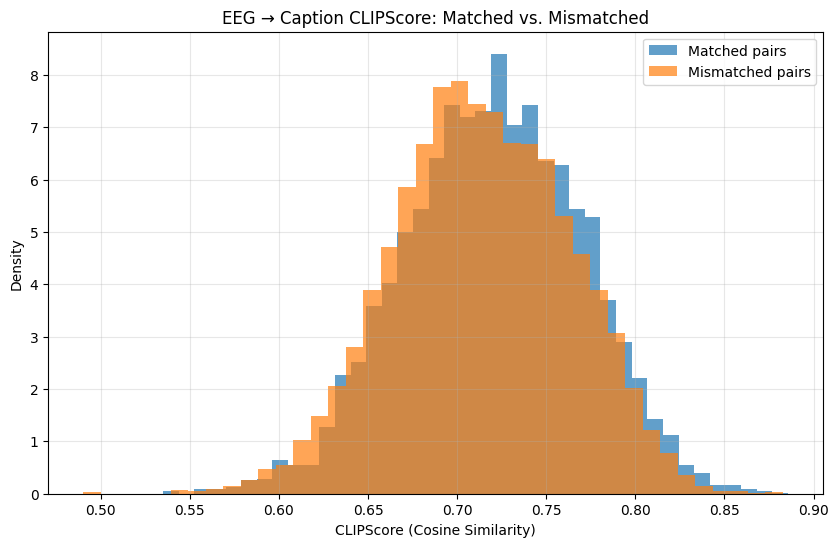

In [34]:


# %%
print("Computing CLIPScore distributions for EEG → Caption...")

eeg_emb = eeg_emb_test        # [N_test, d]
txt_bank = text_emb_bank      # [N_caps, d]
true_cap_idx = caption_idx_test  # [N_test]

N = eeg_emb.size(0)

matched_scores = []
mismatched_scores = []

# --- Matched EEG↔Caption similarity ---
for i in range(N):
    eeg_vec = eeg_emb[i : i+1]                           # [1, d]
    cap_idx = true_cap_idx[i]
    txt_vec = txt_bank[cap_idx : cap_idx+1]             # [1, d]
    sim = torch.matmul(eeg_vec, txt_vec.T).item()
    matched_scores.append(sim)

# --- Mismatched EEG↔Random Caption similarity ---
rng = np.random.default_rng()
for i in range(N):
    eeg_vec = eeg_emb[i : i+1]
    
    # Select random caption not equal to true one
    cap_idx = true_cap_idx[i]
    choices = [j for j in range(len(txt_bank)) if j != cap_idx]
    neg_idx = rng.choice(choices)
    
    txt_vec = txt_bank[neg_idx : neg_idx+1]
    sim = torch.matmul(eeg_vec, txt_vec.T).item()
    mismatched_scores.append(sim)

matched_scores  = np.array(matched_scores)
mismatched_scores = np.array(mismatched_scores)

print(f"Matched CLIPScore: mean={matched_scores.mean():.4f}, std={matched_scores.std():.4f}")
print(f"Mismatched CLIPScore: mean={mismatched_scores.mean():.4f}, std={mismatched_scores.std():.4f}")

# --- Plot ---
plt.figure(figsize=(10,6))
plt.hist(matched_scores, bins=40, alpha=0.7, label='Matched pairs', density=True)
plt.hist(mismatched_scores, bins=40, alpha=0.7, label='Mismatched pairs', density=True)
plt.xlabel("CLIPScore (Cosine Similarity)")
plt.ylabel("Density")
plt.title("EEG → Caption CLIPScore: Matched vs. Mismatched")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [35]:
# %% [markdown]
# ## EEG → Caption Retrieval: Visualization Examples (Optional)

# %%
def visualize_eeg_caption_retrieval(
    eeg_emb,
    text_emb_bank,
    meta_df,
    unique_captions,
    k=3,
    num_examples=5
):
    """
    Visualize EEG→Caption retrieval examples.
    Shows:
        - Ground truth caption
        - Top-k retrieved captions
        - CLIPScore
    """
    N = len(eeg_emb)
    step = max(1, N // num_examples)

    for i in range(0, N, step):
        if num_examples <= 0:
            break
        num_examples -= 1

        eeg_vec = eeg_emb[i : i+1]    # [1, d]
        sims = (eeg_vec @ text_emb_bank.T).squeeze(0)  # [N_caps]
        top_scores, top_idx = torch.topk(sims, k=k)

        gt_caption = meta_df.iloc[i]["abstracted"]

        print("=" * 70)
        print(f"Example #{i}")
        print(f"**Ground truth caption:** {gt_caption}\n")

        for rank in range(k):
            cap = unique_captions[top_idx[rank]]
            score = top_scores[rank].item()
            is_correct = (cap == gt_caption)

            color = "\033[92m" if is_correct else "\033[91m"
            reset = "\033[0m"

            print(f"{color}Top-{rank+1}: {cap}  (Sim={score:.4f}){reset}")

        print()

# Run visualization
visualize_eeg_caption_retrieval(
    eeg_emb_test,
    text_emb_bank,
    all_meta.iloc[len(eeg_train_meta_full) + len(eeg_val_meta_full):],  # test rows only
    unique_captions,
    k=3,
    num_examples=5
)

Example #0
**Ground truth caption:** Wooden diningtable with matching chairs on hardwood floor

Top-1: Bus parked on street beside brick building  (Sim=0.8215)
Top-2: White bus driving on a city street  (Sim=0.8202)
Top-3: Bus parked near a large brick building  (Sim=0.8196)

Example #1040
**Ground truth caption:** Blue car parked on asphalt near mountains

Top-1: Decorative bottle collection on a wooden table  (Sim=0.8867)
Top-2: Colorful bottle display arranged on a table  (Sim=0.8768)
Top-3: Bottle of assorted sodas on a table  (Sim=0.8759)

Example #2080
**Ground truth caption:** Blue sofa with two black cushions nearby table

Top-1: Person smiling while sitting in a chair  (Sim=0.8298)
Top-2: Flower with pale petals and dark center  (Sim=0.8155)
Top-3: Bird perched on a wicker chair  (Sim=0.8139)

Example #3120
**Ground truth caption:** Cow grazing on a grassy open field

Top-1: Cat resting on a soft grey surface  (Sim=0.8788)
Top-2: Cat resting on a soft surface  (Sim=0.8766)
Top

## Comprehensive Evaluation Metrics

In [37]:
# %%
# Import evaluation metrics utilities
from sklearn.metrics import average_precision_score
try:
    from bert_score import score as bert_score
    HAS_BERTSCORE = True
except ImportError:
    print("BERTScore not available. Install with: pip install bert-score")
    HAS_BERTSCORE = False

print("=" * 80)
print("COMPREHENSIVE EVALUATION METRICS FOR EEG-CAPTION RETRIEVAL")
print("Section 5.4.3 & 5.6: All metrics from Task 2A applied to EEG results")
print("=" * 80)

# ---- 1. RECALL@K INSTANCE-LEVEL ----
print("\n1. RECALL@K (Instance-Level)")
print("-" * 80)

def compute_recall_at_k_instance(retrieved_idx, true_idx, k_values=(1, 3, 5)):
    """Exact ground-truth caption match"""
    results = {}
    N = len(true_idx)
    for k in k_values:
        correct = sum(true_idx[i] in retrieved_idx[i, :k] for i in range(N))
        results[f"Recall@{k}"] = correct / N
    return results

recall_instance = compute_recall_at_k_instance(retrieved_idx, caption_idx_test, k_values=(1, 3, 5))
for metric, value in recall_instance.items():
    print(f"  {metric}: {value:.4f}")

# ---- 2. RECALL@K CLASS-AWARE ----
print("\n2. RECALL@K (Class-Aware)")
print("-" * 80)

# Get class/category information from test metadata
test_meta = all_meta.iloc[len(eeg_train_meta_full) + len(eeg_val_meta_full):]

# Check if "category" column exists, if not use "class_id"
if "category" in all_meta.columns:
    category_col = "category"
else:
    category_col = "class_id"
    print(f"Note: Using '{category_col}' for class-aware metrics")

test_categories = test_meta[category_col].values

# Build caption_idx -> category mapping
caption_idx_to_category = {}
for idx, cap in enumerate(unique_captions):
    # Find which category this caption belongs to
    matching_rows = all_meta[all_meta["abstracted"] == cap]
    if len(matching_rows) > 0:
        caption_idx_to_category[idx] = matching_rows.iloc[0][category_col]

def compute_recall_at_k_class_aware(retrieved_idx, true_idx, caption_idx_to_category, k_values=(1, 3, 5)):
    """Any caption from same semantic class"""
    results = {}
    N = len(true_idx)
    for k in k_values:
        correct = 0
        for i in range(N):
            true_cat = caption_idx_to_category.get(true_idx[i], None)
            if true_cat is None:
                continue
            # Check if any of top-k has same category
            retrieved_cats = [caption_idx_to_category.get(j, None) for j in retrieved_idx[i, :k]]
            if true_cat in retrieved_cats:
                correct += 1
        results[f"Class-aware Recall@{k}"] = correct / N
    return results

recall_class_aware = compute_recall_at_k_class_aware(retrieved_idx, caption_idx_test, caption_idx_to_category, k_values=(1, 3, 5))
for metric, value in recall_class_aware.items():
    print(f"  {metric}: {value:.4f}")

# ---- 3. CLIPSCORE DISTRIBUTION ----
print("\n3. CLIPSCORE (Cosine Similarity Distribution)")
print("-" * 80)
print(f"  Matched CLIPScore: mean={matched_scores.mean():.4f}, std={matched_scores.std():.4f}")
print(f"  Mismatched CLIPScore: mean={mismatched_scores.mean():.4f}, std={mismatched_scores.std():.4f}")
print(f"  Separation (mean diff): {matched_scores.mean() - mismatched_scores.mean():.4f}")

# ---- 4. MEAN AVERAGE PRECISION (MAP) ----
print("\n4. MEAN AVERAGE PRECISION (MAP)")
print("-" * 80)

# Compute similarity matrix for test set
sim_matrix = eeg_emb_test @ text_emb_bank.T  # [N_test, N_captions]

def compute_map_caption_level(sim_matrix, gt_idx):
    """Overall MAP: only exact ground-truth caption is relevant"""
    sim = sim_matrix.cpu().numpy() if hasattr(sim_matrix, 'cpu') else sim_matrix.numpy()
    aps = []
    for i, gt in enumerate(gt_idx):
        y_true = np.zeros(sim.shape[1])
        y_true[gt] = 1
        ap = average_precision_score(y_true, sim[i])
        aps.append(ap)
    return float(np.mean(aps)), aps

def compute_map_class_aware(sim_matrix, gt_idx, caption_idx_to_category):
    """Class-aware MAP: any caption from same class is relevant"""
    sim = sim_matrix.cpu().numpy() if hasattr(sim_matrix, 'cpu') else sim_matrix.numpy()
    
    # Build category to caption indices mapping
    cat_to_cap_idx = {}
    for cap_idx, cat in caption_idx_to_category.items():
        if cat not in cat_to_cap_idx:
            cat_to_cap_idx[cat] = []
        cat_to_cap_idx[cat].append(cap_idx)
    
    aps = []
    for i, gt in enumerate(gt_idx):
        y_true = np.zeros(sim.shape[1])
        gt_cat = caption_idx_to_category.get(gt, None)
        if gt_cat is not None and gt_cat in cat_to_cap_idx:
            for cap_idx in cat_to_cap_idx[gt_cat]:
                y_true[cap_idx] = 1
        ap = average_precision_score(y_true, sim[i]) if y_true.sum() > 0 else 0.0
        aps.append(ap)
    return float(np.mean(aps)), aps

def compute_map_per_class(sim_matrix, gt_idx, caption_idx_to_category):
    """Per-class MAP: compute MAP separately for each semantic class"""
    sim = sim_matrix.cpu().numpy() if hasattr(sim_matrix, 'cpu') else sim_matrix.numpy()
    
    # Build category to caption indices mapping
    cat_to_cap_idx = {}
    for cap_idx, cat in caption_idx_to_category.items():
        if cat not in cat_to_cap_idx:
            cat_to_cap_idx[cat] = []
        cat_to_cap_idx[cat].append(cap_idx)
    
    results = {}
    for cat in sorted(set(caption_idx_to_category.values())):
        aps = []
        for i, gt in enumerate(gt_idx):
            if caption_idx_to_category.get(gt, None) != cat:
                continue
            y_true = np.zeros(sim.shape[1])
            y_true[gt] = 1
            ap = average_precision_score(y_true, sim[i])
            aps.append(ap)
        results[cat] = float(np.mean(aps)) if aps else 0.0
    return results

map_caption, map_caption_aps = compute_map_caption_level(sim_matrix, caption_idx_test)
print(f"  Overall (Caption-level) MAP: {map_caption:.4f}")

map_class_aware_val, map_class_aps = compute_map_class_aware(sim_matrix, caption_idx_test, caption_idx_to_category)
print(f"  Class-aware MAP: {map_class_aware_val:.4f}")

map_per_class_results = compute_map_per_class(sim_matrix, caption_idx_test, caption_idx_to_category)
print(f"\n  Per-class MAP:")
for cat, map_val in sorted(map_per_class_results.items()):
    print(f"    {cat}: {map_val:.4f}")
print(f"    Mean: {np.mean(list(map_per_class_results.values())):.4f}")

# ---- 5. BERTSCORE ----
print("\n5. BERTSCORE")
print("-" * 80)

if HAS_BERTSCORE:
    # Sample subset for BERTScore computation (can be slow)
    sample_size = min(500, len(caption_idx_test))
    sample_idx = np.random.choice(len(caption_idx_test), size=sample_size, replace=False)
    
    # Get retrieved top-1 captions for sampled indices
    retrieved_top1_idx = retrieved_idx[sample_idx, 0]
    retrieved_captions = [unique_captions[idx] for idx in retrieved_top1_idx]
    gt_captions = [unique_captions[caption_idx_test[i]] for i in sample_idx]
    
    # Compute BERTScore F1
    try:
        P, R, F1 = bert_score(retrieved_captions, gt_captions, lang='en', device=str(device), verbose=False)
        F1_scores = F1.cpu().numpy()
        
        print(f"  Sample size: {sample_size}")
        print(f"  BERTScore F1 (Top-1): mean={F1_scores.mean():.4f}, std={F1_scores.std():.4f}")
        print(f"  High similarity rate (F1 > 0.7): {(F1_scores > 0.7).mean():.4f}")
        print(f"  Excellent similarity rate (F1 > 0.85): {(F1_scores > 0.85).mean():.4f}")
    except Exception as e:
        print(f"  Error computing BERTScore: {e}")
else:
    print("  BERTScore not available. Install with: pip install bert-score")

print("\n" + "=" * 80)
print("EVALUATION SUMMARY")
print("=" * 80)

COMPREHENSIVE EVALUATION METRICS FOR EEG-CAPTION RETRIEVAL
Section 5.4.3 & 5.6: All metrics from Task 2A applied to EEG results

1. RECALL@K (Instance-Level)
--------------------------------------------------------------------------------
  Recall@1: 0.0000
  Recall@3: 0.0002
  Recall@5: 0.0006

2. RECALL@K (Class-Aware)
--------------------------------------------------------------------------------
Note: Using 'class_id' instead of 'category' for class-aware metrics
  Class-aware Recall@1: 0.0667
  Class-aware Recall@3: 0.0838
  Class-aware Recall@5: 0.0952

3. CLIPSCORE (Cosine Similarity Distribution)
--------------------------------------------------------------------------------
  Matched CLIPScore: mean=0.7204, std=0.0497
  Mismatched CLIPScore: mean=0.7134, std=0.0495
  Separation (mean diff): 0.0070

4. MEAN AVERAGE PRECISION (MAP)
--------------------------------------------------------------------------------
  Class-aware Recall@1: 0.0667
  Class-aware Recall@3: 0.0838
  Cl

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Sample size: 500
  BERTScore F1 (Top-1): mean=0.8641, std=0.0245
  High similarity rate (F1 > 0.7): 1.0000
  Excellent similarity rate (F1 > 0.85): 0.7120

EVALUATION SUMMARY


In [38]:
# %%
# Create summary table of all metrics
import pandas as pd

summary_data = {
    'Metric': [],
    'Value': [],
    'Description': []
}

# Instance-level Recall@K
for k, v in recall_instance.items():
    summary_data['Metric'].append(k)
    summary_data['Value'].append(f"{v:.4f}")
    summary_data['Description'].append("Exact caption match (instance-level)")

# Class-aware Recall@K
for k, v in recall_class_aware.items():
    summary_data['Metric'].append(k)
    summary_data['Value'].append(f"{v:.4f}")
    summary_data['Description'].append("Same semantic class match")

# CLIPScore
summary_data['Metric'].append("CLIPScore (Matched) Mean")
summary_data['Value'].append(f"{matched_scores.mean():.4f}")
summary_data['Description'].append("Cosine similarity for correct pairs")

summary_data['Metric'].append("CLIPScore (Mismatched) Mean")
summary_data['Value'].append(f"{mismatched_scores.mean():.4f}")
summary_data['Description'].append("Cosine similarity for random pairs")

# MAP
summary_data['Metric'].append("MAP (Overall)")
summary_data['Value'].append(f"{map_caption:.4f}")
summary_data['Description'].append("Caption-level: exact caption relevant")

summary_data['Metric'].append("MAP (Class-Aware)")
summary_data['Value'].append(f"{map_class_aware_val:.4f}")
summary_data['Description'].append("Class-level: any class caption relevant")

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Export results to CSV for reporting
results_csv_path = Path(config['root_clip']) / "eeg_retrieval_results.csv"
summary_df.to_csv(results_csv_path, index=False)
print(f"\n✓ Results saved to: {results_csv_path}")

# Create per-class MAP table
print("\n\nPer-Class MAP Breakdown:")
print("-" * 60)
per_class_df = pd.DataFrame({
    'Category': list(map_per_class_results.keys()),
    'MAP': [f"{v:.4f}" for v in map_per_class_results.values()]
})
print(per_class_df.to_string(index=False))

per_class_csv_path = Path(config['root_clip']) / "eeg_retrieval_per_class_map.csv"
per_class_df.to_csv(per_class_csv_path, index=False)
print(f"\n✓ Per-class results saved to: {per_class_csv_path}")


                     Metric  Value                             Description
                   Recall@1 0.0000    Exact caption match (instance-level)
                   Recall@3 0.0002    Exact caption match (instance-level)
                   Recall@5 0.0006    Exact caption match (instance-level)
       Class-aware Recall@1 0.0667               Same semantic class match
       Class-aware Recall@3 0.0838               Same semantic class match
       Class-aware Recall@5 0.0952               Same semantic class match
   CLIPScore (Matched) Mean 0.7204     Cosine similarity for correct pairs
CLIPScore (Mismatched) Mean 0.7134      Cosine similarity for random pairs
              MAP (Overall) 0.0013   Caption-level: exact caption relevant
          MAP (Class-Aware) 0.1034 Class-level: any class caption relevant

✓ Results saved to: /jet/home/bermudez/exploring-eeg/5-caption-retrieval/eeg_retrieval_results.csv


Per-Class MAP Breakdown:
-----------------------------------------------

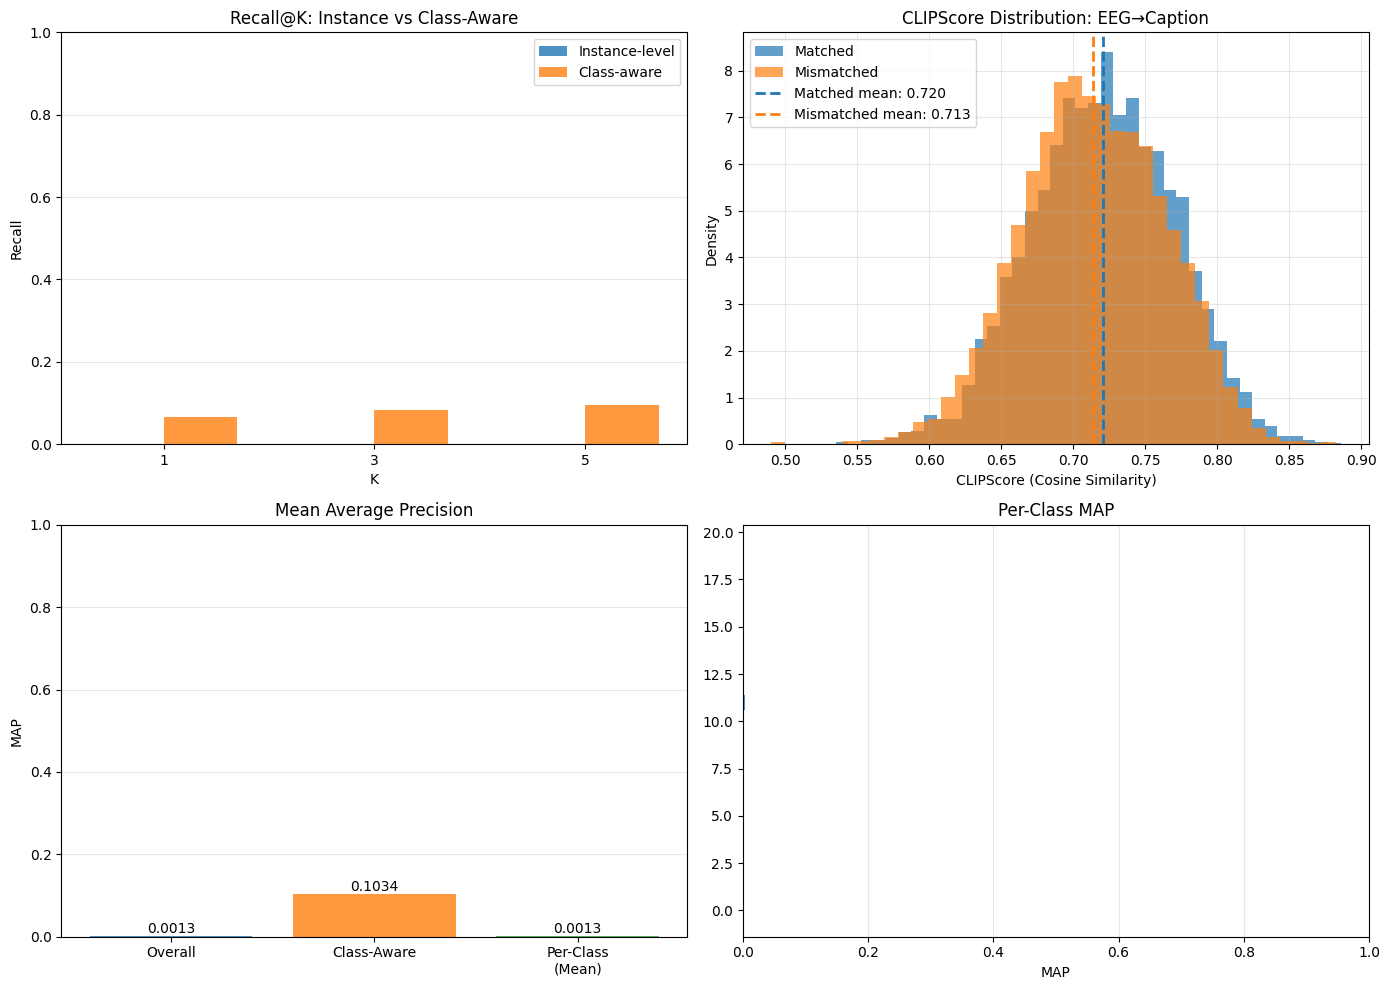


✓ Evaluation visualization complete!


In [40]:
# %%
# Visualization: Key metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Recall@K comparison (instance vs class-aware)
ax = axes[0, 0]
k_values = ['1', '3', '5']
instance_vals = [recall_instance[f"Recall@{k}"] for k in k_values]
class_aware_vals = [recall_class_aware[f"Class-aware Recall@{k}"] for k in k_values]

x = np.arange(len(k_values))
width = 0.35
ax.bar(x - width/2, instance_vals, width, label='Instance-level', alpha=0.8)
ax.bar(x + width/2, class_aware_vals, width, label='Class-aware', alpha=0.8)
ax.set_xlabel('K')
ax.set_ylabel('Recall')
ax.set_title('Recall@K: Instance vs Class-Aware')
ax.set_xticks(x)
ax.set_xticklabels(k_values)
ax.legend()
ax.grid(alpha=0.3, axis='y')
ax.set_ylim([0, 1])

# 2. CLIPScore distribution
ax = axes[0, 1]
ax.hist(matched_scores, bins=40, alpha=0.7, label='Matched', density=True)
ax.hist(mismatched_scores, bins=40, alpha=0.7, label='Mismatched', density=True)
ax.axvline(matched_scores.mean(), color='C0', linestyle='--', linewidth=2, label=f'Matched mean: {matched_scores.mean():.3f}')
ax.axvline(mismatched_scores.mean(), color='C1', linestyle='--', linewidth=2, label=f'Mismatched mean: {mismatched_scores.mean():.3f}')
ax.set_xlabel('CLIPScore (Cosine Similarity)')
ax.set_ylabel('Density')
ax.set_title('CLIPScore Distribution: EEG→Caption')
ax.legend()
ax.grid(alpha=0.3)

# 3. MAP comparison
ax = axes[1, 0]
map_vals = [map_caption, map_class_aware_val, np.mean(list(map_per_class_results.values()))]
map_labels = ['Overall', 'Class-Aware', 'Per-Class\n(Mean)']
bars = ax.bar(map_labels, map_vals, alpha=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('MAP')
ax.set_title('Mean Average Precision')
ax.set_ylim([0, 1])
ax.grid(alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars, map_vals):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# 4. Per-class MAP distribution
ax = axes[1, 1]
sorted_categories = sorted(map_per_class_results.keys())
sorted_maps = [map_per_class_results[cat] for cat in sorted_categories]
bars = ax.barh(sorted_categories, sorted_maps, alpha=0.8)
ax.set_xlabel('MAP')
ax.set_title('Per-Class MAP')
ax.set_xlim([0, 1])
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✓ Evaluation visualization complete!")